In [1]:
#読み込むチャンネルなどの設定

import lal
import lalframe
import numpy as np
import scipy
from matplotlib import pyplot as plt

# Location of strain data
str_dir = "../../../Hongo-Data-1/iKAGRA/proc/11447/"
#str_dir = "/Hongo-Data-1/iKAGRA/proc/11447/"
str_root = [
    #"K-K1_PROC_C00-1144700000-32.gwf",
    #"K-K1_PROC_C00-1144700032-32.gwf",
    #"K-K1_PROC_C00-1144700064-32.gwf",
    #"K-K1_PROC_C00-1144700096-32.gwf",
    "K-K1_PROC_C00-1144700128-32.gwf",
    "K-K1_PROC_C00-1144700160-32.gwf"#,
    #"K-K1_PROC_C00-1144700192-32.gwf",
    #"K-K1_PROC_C00-1144700224-32.gwf",
    #"K-K1_PROC_C00-1144700256-32.gwf",
    #"K-K1_PROC_C00-1144700288-32.gwf",
    #"K-K1_PROC_C00-1144700320-32.gwf"
]
str_idx = 1 # strain channel

# Location of enviroment data
env_dir = "../../../Hongo-Data-1/iKAGRA/full/11447/"
#env_dir = "/Hongo-Data-1/iKAGRA/full/11447/"
env_root = [
    #"K-K1_C-1144700000-32.gwf",
    #"K-K1_C-1144700032-32.gwf",
    #"K-K1_C-1144700064-32.gwf",
    #"K-K1_C-1144700096-32.gwf",
    "K-K1_C-1144700128-32.gwf",
    "K-K1_C-1144700160-32.gwf"#,
    #"K-K1_C-1144700192-32.gwf",
    #"K-K1_C-1144700224-32.gwf",
    #"K-K1_C-1144700256-32.gwf",
    #"K-K1_C-1144700288-32.gwf",
    #"K-K1_C-1144700320-32.gwf"
]
env_idx = 8951 # enviroment channel

num_files = len(str_root)

# Location of output
outdir = "./test/test_cont/"
outroot = "K-K1_1144700000-32"

In [35]:
#ストレインおよび環境チャンネルの読み込み

from lalframe.utils import frtools
from lalframe import frread

dur = 0.
for i in range(num_files):
    fname = str_dir+str_root[i]
    str_ch = frtools.get_channels(fname)
    data_strain = frread.read_timeseries(fname,channel=str_ch[str_idx])

    fname = env_dir+env_root[i]
    env_ch = frtools.get_channels(fname)
    data_env = frread.read_timeseries(fname,channel=env_ch[env_idx])

    t_str = data_strain.deltaT*data_strain.data.data.size
    t_env = data_env.deltaT*data_env.data.data.size
    if  t_str != t_env: # check if duration of strain and environment data are the same
        print "Error: durations of strain and environment data do not match"
    dur += t_str

    if i==0: 
        strain = np.array(data_strain.data.data)
        env = np.array(data_env.data.data)
    else:
        strain = np.append(strain,data_strain.data.data)
        env = np.append(env,data_env.data.data)

num_str = strain.size
num_env = env.size

fs_env = num_env/dur
fs_str = num_str/dur

print "Duration:",dur
print "Number of points in strain data:",num_str
print "Number of points in environment data:",num_env
print "Sampling frequency of strain data:",fs_str
print "Sampling frequency of environment data:",fs_env

Duration: 64.0
Number of points in strain data: 1048576
Number of points in environment data: 1024
Sampling frequency of strain data: 16384.0
Sampling frequency of environment data: 16.0


In [36]:
#ダウンサンプリング
import scipy.signal as sig

num_t = min(num_str,num_env)
#num_t = max(num_str,num_env)

print "Number of data points for ICA:",num_t
fs = num_t/dur
print "Sampling rate:",fs
arr_time = np.linspace(0,dur,num_t)

arr_str = np.empty(num_t,dtype=float)
arr_str = sig.resample(strain,num_t) # you may get warning here

arr_env = np.empty(num_t,dtype=float)
arr_env = sig.resample(env,num_t) # you may get warning here


Number of data points for ICA: 1024
Sampling rate: 16.0


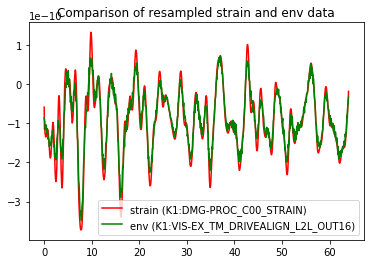

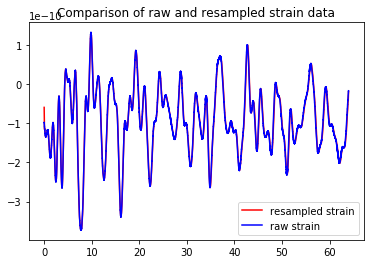

In [37]:
#データのプロット

#normalization factor only for visualization
norm_env = 1.2e12

plt.figure()
plt.title('Comparison of resampled strain and env data')
plt.plot(arr_time,arr_str,'r',label='strain ('+str_ch[str_idx]+')')
plt.plot(arr_time,arr_env/norm_env,'g',label='env ('+env_ch[env_idx]+')')
plt.legend()
plt.show()

plt.figure()
plt.title('Comparison of raw and resampled strain data')
plt.plot(arr_time,arr_str,'r',label='resampled strain')
plt.plot(np.arange(dur,step=1/fs_str),strain,'b',label='raw strain')
plt.legend()
plt.show()

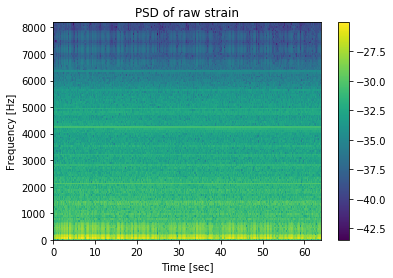

In [38]:
#生のストレインデータのPSD
f,t,Sxx = sig.spectrogram(strain,fs_str)

plt.figure()
plt.title('PSD of raw strain')
plt.pcolormesh(t, f, np.log10(Sxx))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.show()

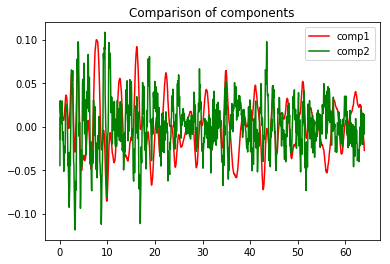

In [39]:
#FastICA
#%%timeit
from sklearn.decomposition import FastICA, PCA

X = np.c_[arr_str,arr_env]
ica = FastICA(n_components=2,whiten=True)
S = ica.fit_transform(X)
A = ica.mixing_  # Retrieving estimated mixing matrix

#独立成分のプロット
plt.figure()
plt.title('Comparison of components')
plt.plot(arr_time,S[:,0],'r',label="comp1")
plt.plot(arr_time,S[:,1],'g',label="comp2")
plt.legend()
plt.show()

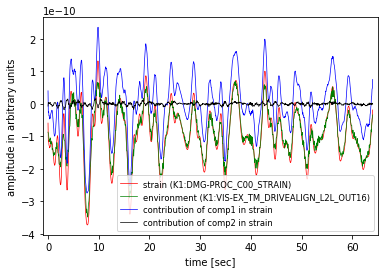

In [40]:
#各成分のストレインデータへの寄与の計算
X_ = np.dot(S,A.T) # 

S0 = np.zeros(np.shape(S))
S1 = np.zeros(np.shape(S))
S0[:,0] = S[:,0]
S1[:,1] = S[:,1]

X0_ = np.dot(S0,A.T)
X1_ = np.dot(S1,A.T)

#plt.figure(figsize=(5,4),dpi=500)
plt.plot(arr_time,X[:,0],'r-',linewidth = 0.7,label='strain ('+str_ch[str_idx]+')')
plt.plot(arr_time,X[:,1]/norm_env,'g-',linewidth = 0.7,label='environment ('+env_ch[env_idx]+')')
plt.plot(arr_time,X0_[:,0],'b-',linewidth = 0.7,label='contribution of comp1 in strain')
plt.plot(arr_time,X1_[:,0],'k-',linewidth = 0.7,label='contribution of comp2 in strain')

plt.xlim(-1,dur+1)
#plt.ylim(-5e-10,5e-10)
plt.ylabel("amplitude in arbitrary units")
plt.xlabel("time [sec]")
plt.legend(fontsize='small')
#plt.savefig(outdir+outroot+'.png') 
plt.show()

In [41]:
#### 適当なテンプレートの作成
import math

#parameter for the tempelate
amp = 2.E-11
fudge_omega = 12.
omega = fs/fudge_omega
print(omega)

arr_temp = np.empty(num_t)
for i in range(num_t):
    dt = (i-num_t/2)/fs
    arr_temp[i] = math.cos(dt*omega)*amp

1.33333333333


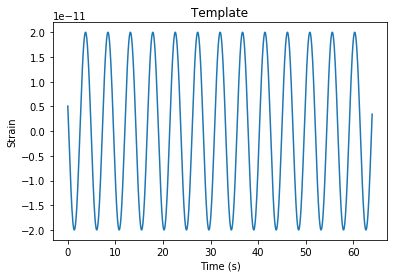

In [42]:
#テンプレートのプロット

plt.figure()
plt.plot(np.arange(dur,step=1./fs),arr_temp)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Template')
plt.show()

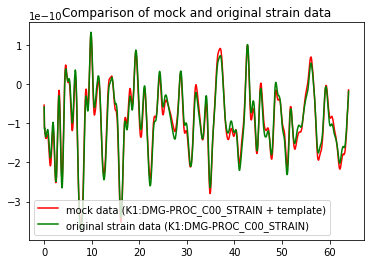

In [43]:
#モックデータの作成とプロット
arr_mock = np.array(arr_str,copy=True)
#arr_mock[offset_temp:offset_temp+num_temp] += arr_temp
arr_mock += arr_temp

plt.figure()
plt.title('Comparison of mock and original strain data')
plt.plot(arr_time,arr_mock,'r',label='mock data ('+str_ch[str_idx]+' + template)')
plt.plot(arr_time,arr_str,'g',label='original strain data ('+str_ch[str_idx]+')')
plt.legend()
plt.show()

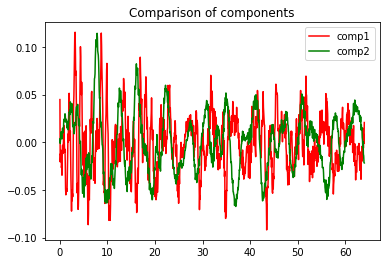

In [46]:
#モックデータを用いたFastICA
Xm = np.c_[arr_mock,arr_env]
icam = FastICA(n_components=2)
Sm = icam.fit_transform(Xm)
Am = icam.mixing_  # Retrieving estimated mixing matrix

# Plotting components
plt.figure()
plt.title('Comparison of components')
plt.plot(arr_time,Sm[:,0],'r',label="comp1")
plt.plot(arr_time,Sm[:,1],'g',label="comp2")
plt.legend()
plt.show()

# Plotting strain data separately
Xm_ = np.dot(Sm,Am.T) # 

S0m = np.zeros(np.shape(Sm))
S1m = np.zeros(np.shape(Sm))
S0m[:,0] = Sm[:,0]
S1m[:,1] = Sm[:,1]

X0m_ = np.dot(S0m,Am.T)
X1m_ = np.dot(S1m,Am.T)

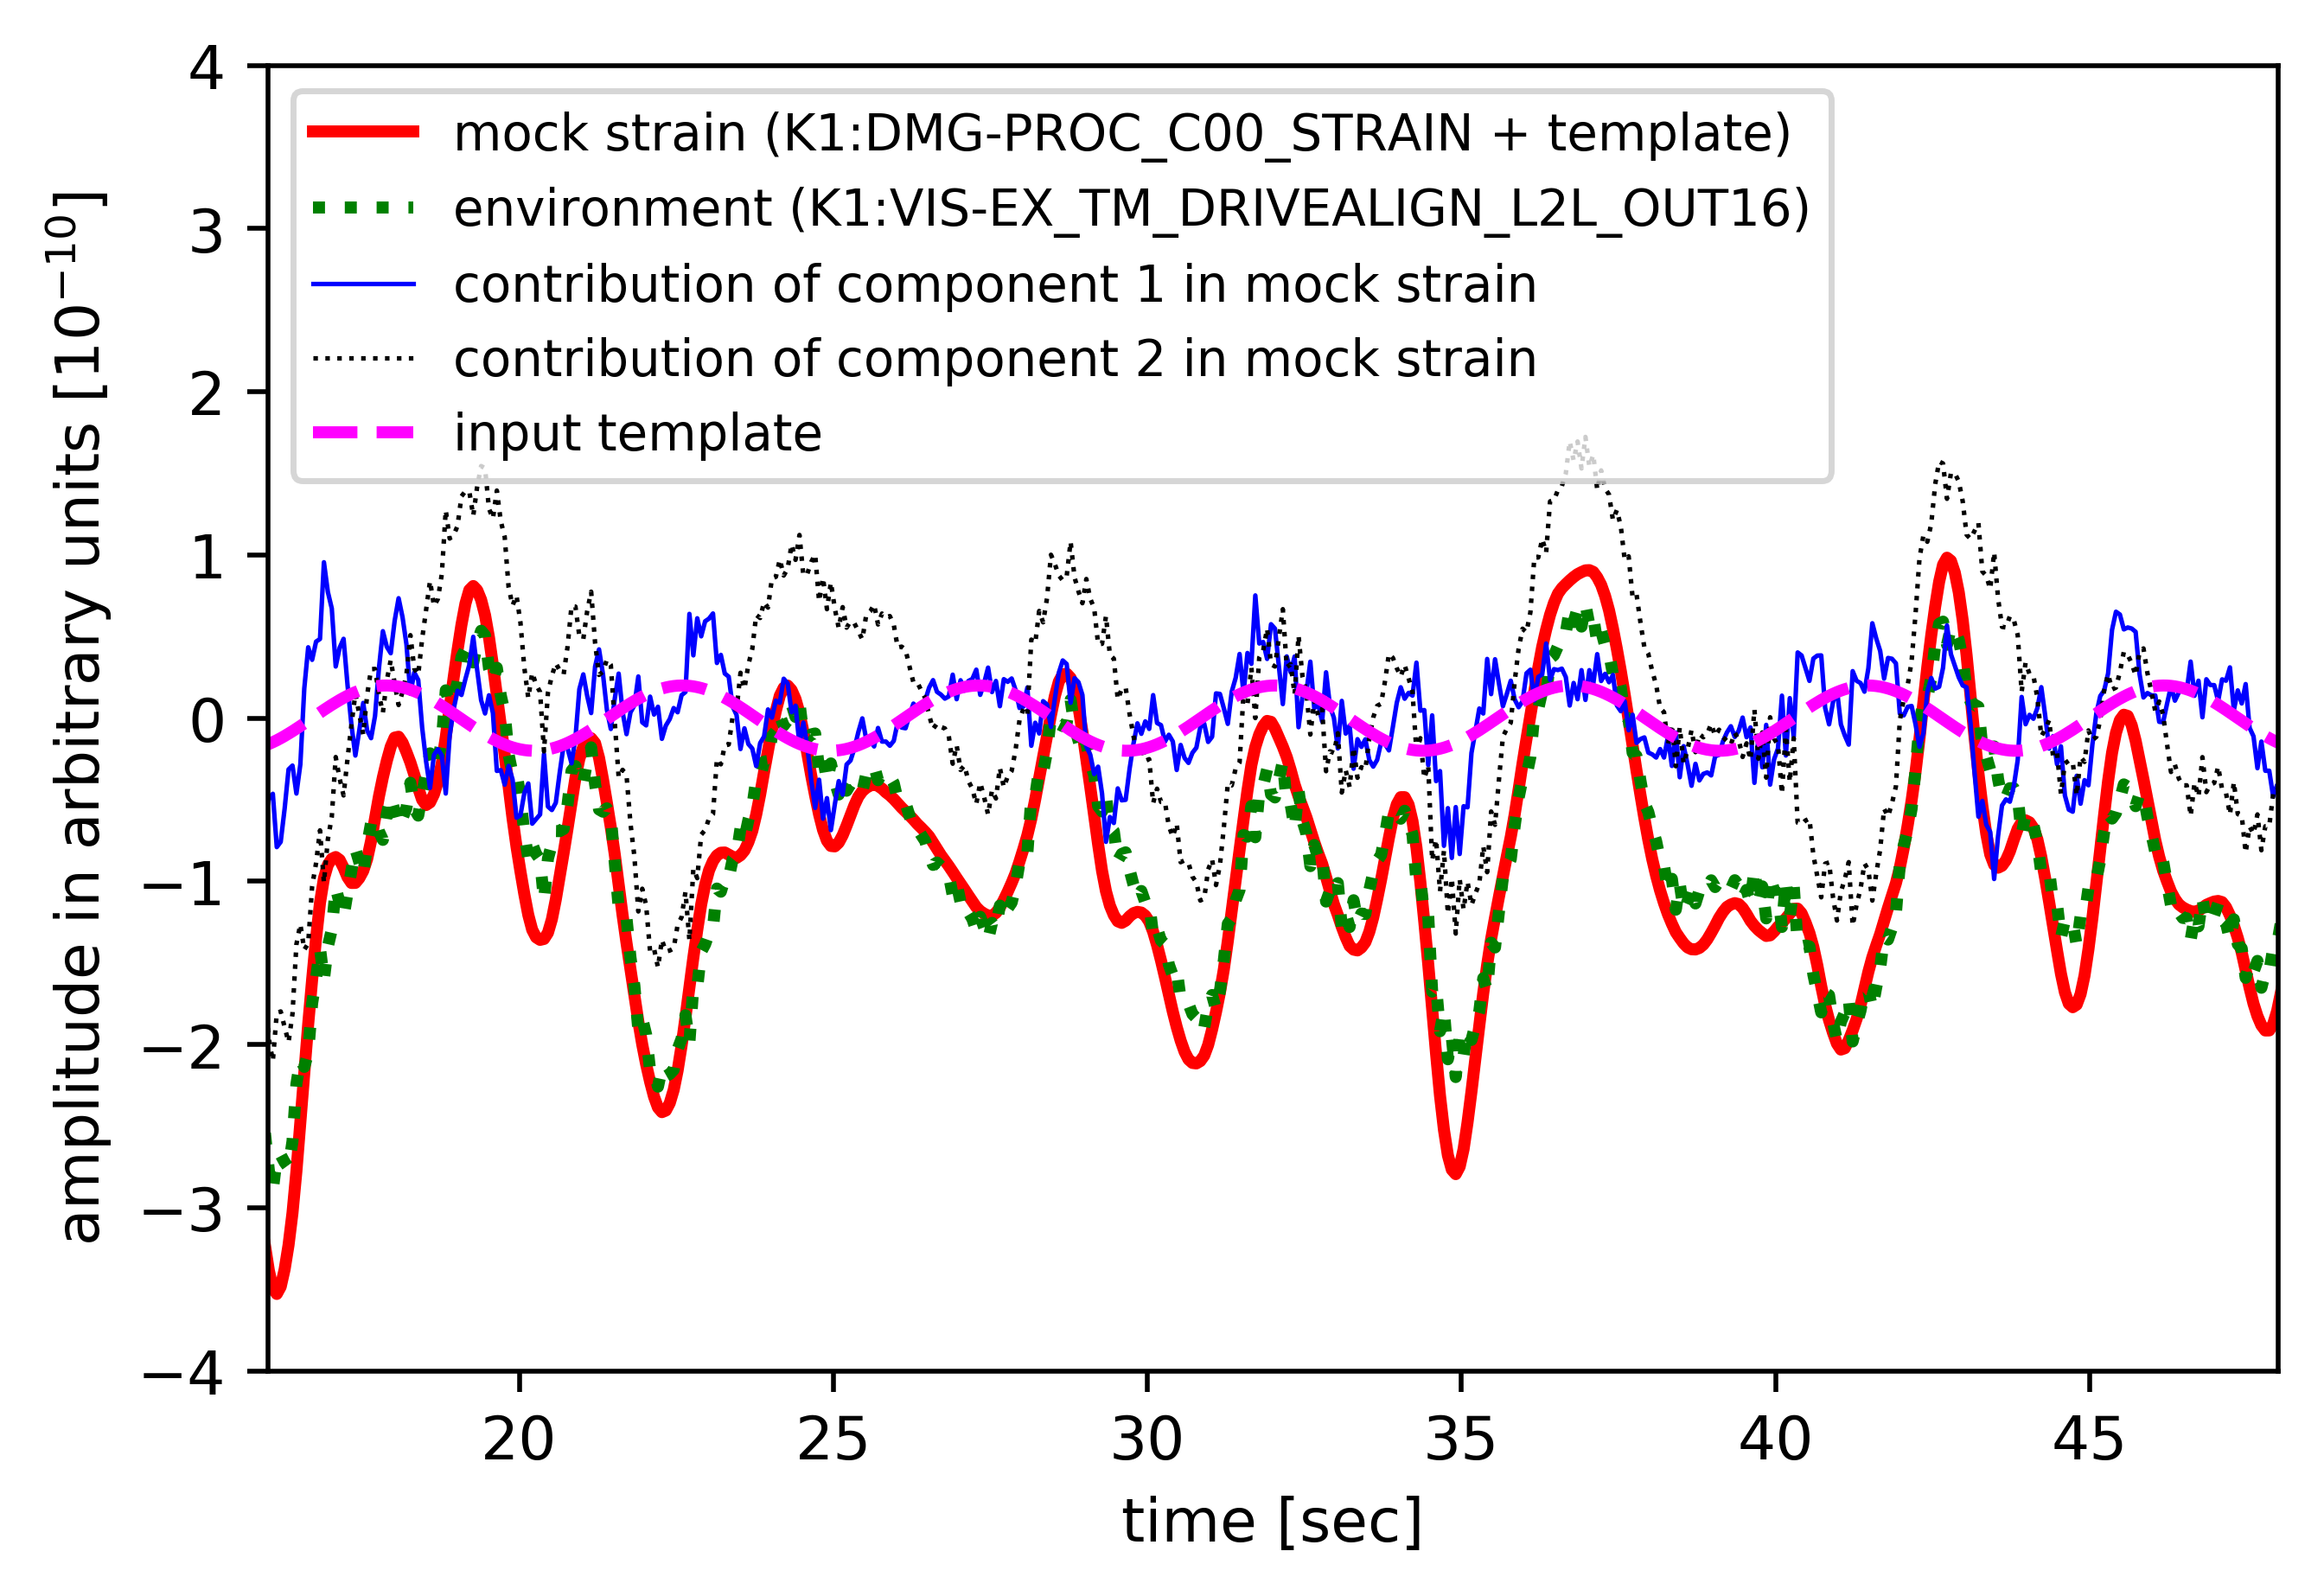

In [52]:
norm=1e-10
plt.figure(dpi=500)
plt.plot(arr_time,Xm[:,0]/norm,color='red',linestyle='solid',linewidth = 2.,label='mock strain ('+str_ch[str_idx]+' + template)')
plt.plot(arr_time,Xm[:,1]/norm_env/norm,color='green',linestyle='dotted',linewidth = 2.,label='environment ('+env_ch[env_idx]+')')
plt.plot(arr_time,X0m_[:,0]/norm,color='blue',linestyle='solid',linewidth = .75,label=r'contribution of component 1 in mock strain ')#,label=str_ch[str_idx])
plt.plot(arr_time,X1m_[:,0]/norm,color='black',linestyle='dotted',linewidth = .75,label=r'contribution of component 2 in mock strain ')#,label=str_ch[str_idx])
plt.plot(arr_time,arr_temp/norm,color='magenta',linestyle='dashed',linewidth = 2.,label=r'input template ')#,label=str_ch[str_idx])


plt.xlim(16,48)
#plt.xlim(-1,dur+1)
plt.ylim(-4.e-10/norm,4.e-10/norm)
plt.ylabel(u"amplitude in arbitrary units [10$^{-10}$]")
plt.xlabel(u"time [sec]")
plt.legend(fontsize='small')
plt.savefig(outdir+outroot+'.png')
plt.show()

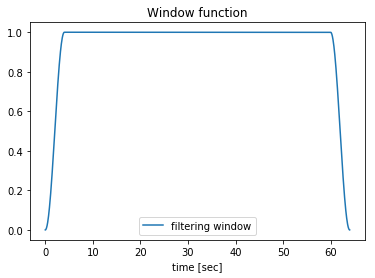

1024


In [53]:
#matched filteringの設定
#matched filteringについては以下のページを参照した
#https://losc.ligo.org/tutorial_optimal/
#https://losc.ligo.org/s/events/GW150914/LOSC_Event_tutorial_GW150914.html#Waveform-Template

NFFT = 4*int(fs)
psd_window = np.blackman(NFFT)
NOVL = NFFT/2 # 50% overlap:

datafreq = np.fft.fftfreq(num_t)*fs
df = np.abs(datafreq[1] - datafreq[0])

# to remove effects at the beginning and end of the data stretch, window the data
# https://en.wikipedia.org/wiki/Window_function#Tukey_window
try:   dwindow = sig.tukey(arr_temp.size, alpha=1./8)  
    # Tukey window preferred, but requires recent scipy version 
except: dwindow = sig.blackman(arr_temp.size)          
    # Blackman window OK if Tukey is not available

# plot of window function
plt.figure()
#plt.plot(arr_time[:NFFT],psd_window,label='psd window')
plt.plot(arr_time,dwindow,label='filtering window')
plt.xlabel('time [sec]')
plt.title('Window function')
plt.legend()
plt.show()

# prepare the template fft
arr_temp_fft = np.fft.fft(arr_temp*dwindow) / fs
print(arr_temp_fft.size)

In [54]:
#matched filteringをmock strainおよび成分ごとのmock strainについて行う
import matplotlib.mlab as mlab

Xm_psd, Xm_freqs = mlab.psd(Xm_[:,0], Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)
X0m_psd, X0m_freqs = mlab.psd(X0m_[:,0], Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)
X1m_psd, X1m_freqs = mlab.psd(X1m_[:,0], Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)

# Take the Fourier Transform (FFT) of the data and the template (with dwindow)
Xm_fft = np.fft.fft(Xm_[:,0]*dwindow) / fs
X0m_fft = np.fft.fft(X0m_[:,0]*dwindow) / fs
X1m_fft = np.fft.fft(X1m_[:,0]*dwindow) / fs

Xm_power_vec = np.interp(np.abs(datafreq), Xm_freqs, Xm_psd)
X0m_power_vec = np.interp(np.abs(datafreq), X0m_freqs, X0m_psd)
X1m_power_vec = np.interp(np.abs(datafreq), X1m_freqs, X1m_psd)

Xm_optimal = Xm_fft * arr_temp_fft.conjugate() / Xm_power_vec
Xm_optimal_time = 2*np.fft.ifft(Xm_optimal)*fs
X0m_optimal = X0m_fft * arr_temp_fft.conjugate() / X0m_power_vec
X0m_optimal_time = 2*np.fft.ifft(X0m_optimal)*fs
X1m_optimal = X1m_fft * arr_temp_fft.conjugate() / X1m_power_vec
X1m_optimal_time = 2*np.fft.ifft(X1m_optimal)*fs

# -- Normalize the matched filter output:
# Normalize the matched filter output so that we expect a value of 1 at times of just noise.
# Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
Xm_sigmasq = 1*(arr_temp_fft * arr_temp_fft.conjugate() / Xm_power_vec).sum() * df
Xm_sigma = np.sqrt(np.abs(Xm_sigmasq))
Xm_SNR_complex = Xm_optimal_time/Xm_sigma
Xm_SNR = abs(Xm_SNR_complex)
X0m_sigmasq = 1*(arr_temp_fft * arr_temp_fft.conjugate() / X0m_power_vec).sum() * df
X0m_sigma = np.sqrt(np.abs(X0m_sigmasq))
X0m_SNR_complex = X0m_optimal_time/X0m_sigma
X0m_SNR = abs(X0m_SNR_complex)
X1m_sigmasq = 1*(arr_temp_fft * arr_temp_fft.conjugate() / X1m_power_vec).sum() * df
X1m_sigma = np.sqrt(np.abs(X1m_sigmasq))
X1m_SNR_complex = X1m_optimal_time/X1m_sigma
X1m_SNR = abs(X1m_SNR_complex)

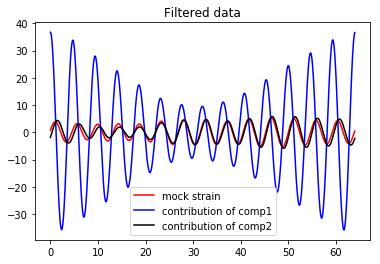

In [55]:
#フィルターされたデータのプロット
#コメント(2018 Sep 01):なぜ環境チャンネルと独立な成分はデータの端で振幅が大きい？
plt.figure()
plt.title('Filtered data')
plt.plot(arr_time, Xm_optimal_time,'r-',label=r'mock strain')
plt.plot(arr_time, X0m_optimal_time,'b-',label=r'contribution of comp1')
plt.plot(arr_time, X1m_optimal_time,'k-',label=r'contribution of comp2')
plt.legend()
plt.show()

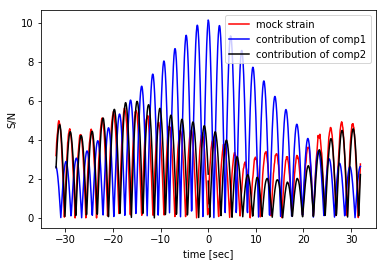

In [56]:
#S/Nのプロット
plt.figure()
#plt.yscale('log')
plt.plot(arr_time[:num_t//2],Xm_SNR[:num_t//2],'r-',label=r'mock strain')
plt.plot(arr_time[:num_t//2],X0m_SNR[:num_t//2],'b-',label=r'contribution of comp1')
plt.plot(arr_time[:num_t//2],X1m_SNR[:num_t//2],'k-',label=r'contribution of comp2')
plt.plot(arr_time[-num_t//2:]-dur,Xm_SNR[-num_t//2:],'r-')
plt.plot(arr_time[-num_t//2:]-dur,X0m_SNR[-num_t//2:],'b-')
plt.plot(arr_time[-num_t//2:]-dur,X1m_SNR[-num_t//2:],'k-')

#plt.xlim([dur/2-dur_temp,dur/2+dur_temp])
plt.xlabel('time [sec]')
plt.ylabel('S/N')
plt.legend()
plt.savefig(outdir+outroot+'_.png')
plt.show()

In [57]:
#matched filteringをmock strainおよび成分ごとのmock strainについて行う

#import matplotlib.mlab as mlab
Xme_psd, Xme_freqs = mlab.psd(Xm_[:,1], Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)

# Take the Fourier Transform (FFT) of the data and the template (with dwindow)
Xme_fft = np.fft.fft(Xm_[:,1]*dwindow) / fs

Xme_power_vec = np.interp(np.abs(datafreq), Xme_freqs, Xme_psd)

Xme_optimal = Xme_fft * arr_temp_fft.conjugate() / Xme_power_vec
Xme_optimal_time = 2*np.fft.ifft(Xme_optimal)*fs

# -- Normalize the matched filter output:
# Normalize the matched filter output so that we expect a value of 1 at times of just noise.
# Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
Xme_sigmasq = 1*(arr_temp_fft * arr_temp_fft.conjugate() / Xme_power_vec).sum() * df
Xme_sigma = np.sqrt(np.abs(Xme_sigmasq))
Xme_SNR_complex = Xme_optimal_time/Xme_sigma
Xme_SNR = abs(Xme_SNR_complex)


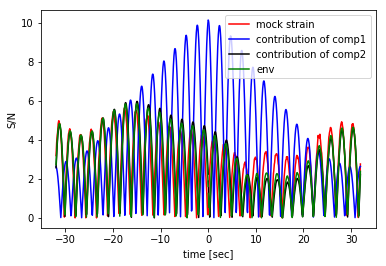

In [58]:
#S/Nのプロット
plt.figure()
#plt.yscale('log')
plt.plot(arr_time[:num_t//2],Xm_SNR[:num_t//2],'r-',label=r'mock strain')
plt.plot(arr_time[:num_t//2],X0m_SNR[:num_t//2],'b-',label=r'contribution of comp1')
plt.plot(arr_time[:num_t//2],X1m_SNR[:num_t//2],'k-',label=r'contribution of comp2')
plt.plot(arr_time[:num_t//2],Xme_SNR[:num_t//2],'g-',label=r'env')
plt.plot(arr_time[-num_t//2:]-dur,Xm_SNR[-num_t//2:],'r-')
plt.plot(arr_time[-num_t//2:]-dur,X0m_SNR[-num_t//2:],'b-')
plt.plot(arr_time[-num_t//2:]-dur,X1m_SNR[-num_t//2:],'k-')
plt.plot(arr_time[-num_t//2:]-dur,Xme_SNR[-num_t//2:],'g-')


#plt.xlim([dur/2-dur_temp,dur/2+dur_temp])
plt.xlabel('time [sec]')
plt.ylabel('S/N')
plt.legend()
plt.savefig(outdir+outroot+'_.png')
plt.show()

In [59]:
domega = omega/20
num_trial = 50

omega_max = np.empty(num_trial)
Xm_SNR_max = np.empty(num_trial)
X0m_SNR_max = np.empty(num_trial)
X1m_SNR_max = np.empty(num_trial)

for j in range(num_trial):
    #parameter for the tempelate
    amp_trial = amp
    omega_trial = domega*(j+1)
    omega_max[j] = omega_trial

    arr_temp = np.empty(num_t)
    for i in range(num_t):
        dt = (i-num_t/2)/fs
        arr_temp[i] = math.cos(dt*omega_trial)*amp_trial
    
    # prepare the template fft
    arr_temp_fft = np.fft.fft(arr_temp*dwindow) / fs

    #matched filteringをmock strainおよび成分ごとのmock strainについて行う
    Xm_psd, Xm_freqs = mlab.psd(Xm_[:,0], Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)
    X0m_psd, X0m_freqs = mlab.psd(X0m_[:,0], Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)
    X1m_psd, X1m_freqs = mlab.psd(X1m_[:,0], Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)

    # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
    Xm_fft = np.fft.fft(Xm_[:,0]*dwindow) / fs
    X0m_fft = np.fft.fft(X0m_[:,0]*dwindow) / fs
    X1m_fft = np.fft.fft(X1m_[:,0]*dwindow) / fs

    Xm_power_vec = np.interp(np.abs(datafreq), Xm_freqs, Xm_psd)
    X0m_power_vec = np.interp(np.abs(datafreq), X0m_freqs, X0m_psd)
    X1m_power_vec = np.interp(np.abs(datafreq), X1m_freqs, X1m_psd)

    Xm_optimal = Xm_fft * arr_temp_fft.conjugate() / Xm_power_vec
    Xm_optimal_time = 2*np.fft.ifft(Xm_optimal)*fs
    X0m_optimal = X0m_fft * arr_temp_fft.conjugate() / X0m_power_vec
    X0m_optimal_time = 2*np.fft.ifft(X0m_optimal)*fs
    X1m_optimal = X1m_fft * arr_temp_fft.conjugate() / X1m_power_vec
    X1m_optimal_time = 2*np.fft.ifft(X1m_optimal)*fs

    # -- Normalize the matched filter output:
    # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
    # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
    Xm_sigmasq = 1*(arr_temp_fft * arr_temp_fft.conjugate() / Xm_power_vec).sum() * df
    Xm_sigma = np.sqrt(np.abs(Xm_sigmasq))
    Xm_SNR_complex = Xm_optimal_time/Xm_sigma
    Xm_SNR = abs(Xm_SNR_complex)
    X0m_sigmasq = 1*(arr_temp_fft * arr_temp_fft.conjugate() / X0m_power_vec).sum() * df
    X0m_sigma = np.sqrt(np.abs(X0m_sigmasq))
    X0m_SNR_complex = X0m_optimal_time/X0m_sigma
    X0m_SNR = abs(X0m_SNR_complex)
    X1m_sigmasq = 1*(arr_temp_fft * arr_temp_fft.conjugate() / X1m_power_vec).sum() * df
    X1m_sigma = np.sqrt(np.abs(X1m_sigmasq))
    X1m_SNR_complex = X1m_optimal_time/X1m_sigma
    X1m_SNR = abs(X1m_SNR_complex)
    
    Xm_SNR_max[j] = Xm_SNR[0]
    X0m_SNR_max[j] = X0m_SNR[0]
    X1m_SNR_max[j] = X1m_SNR[0]
    
    #S/Nのプロット
    #plt.figure()
    #plt.plot(arr_time[:num_t//2],Xm_SNR[:num_t//2],'r-',label=r'mock strain')
    #plt.plot(arr_time[:num_t//2],X0m_SNR[:num_t//2],'b-',label=r'contribution of comp1')
    #plt.plot(arr_time[:num_t//2],X1m_SNR[:num_t//2],'k-',label=r'contribution of comp2')
    #plt.plot(arr_time[-num_t//2:]-dur,Xm_SNR[-num_t//2:],'r-')
    #plt.plot(arr_time[-num_t//2:]-dur,X0m_SNR[-num_t//2:],'b-')
    #plt.plot(arr_time[-num_t//2:]-dur,X1m_SNR[-num_t//2:],'k-')
    #plt.xlabel('time [sec]')
    #plt.ylabel('S/N')
    #plt.legend()
    #lt.show()

    print(j,"done")

(0, 'done')
(1, 'done')
(2, 'done')
(3, 'done')
(4, 'done')
(5, 'done')
(6, 'done')
(7, 'done')
(8, 'done')
(9, 'done')
(10, 'done')
(11, 'done')
(12, 'done')
(13, 'done')
(14, 'done')
(15, 'done')
(16, 'done')
(17, 'done')
(18, 'done')
(19, 'done')
(20, 'done')
(21, 'done')
(22, 'done')
(23, 'done')
(24, 'done')
(25, 'done')
(26, 'done')
(27, 'done')
(28, 'done')
(29, 'done')
(30, 'done')
(31, 'done')
(32, 'done')
(33, 'done')
(34, 'done')
(35, 'done')
(36, 'done')
(37, 'done')
(38, 'done')
(39, 'done')
(40, 'done')
(41, 'done')
(42, 'done')
(43, 'done')
(44, 'done')
(45, 'done')
(46, 'done')
(47, 'done')
(48, 'done')
(49, 'done')


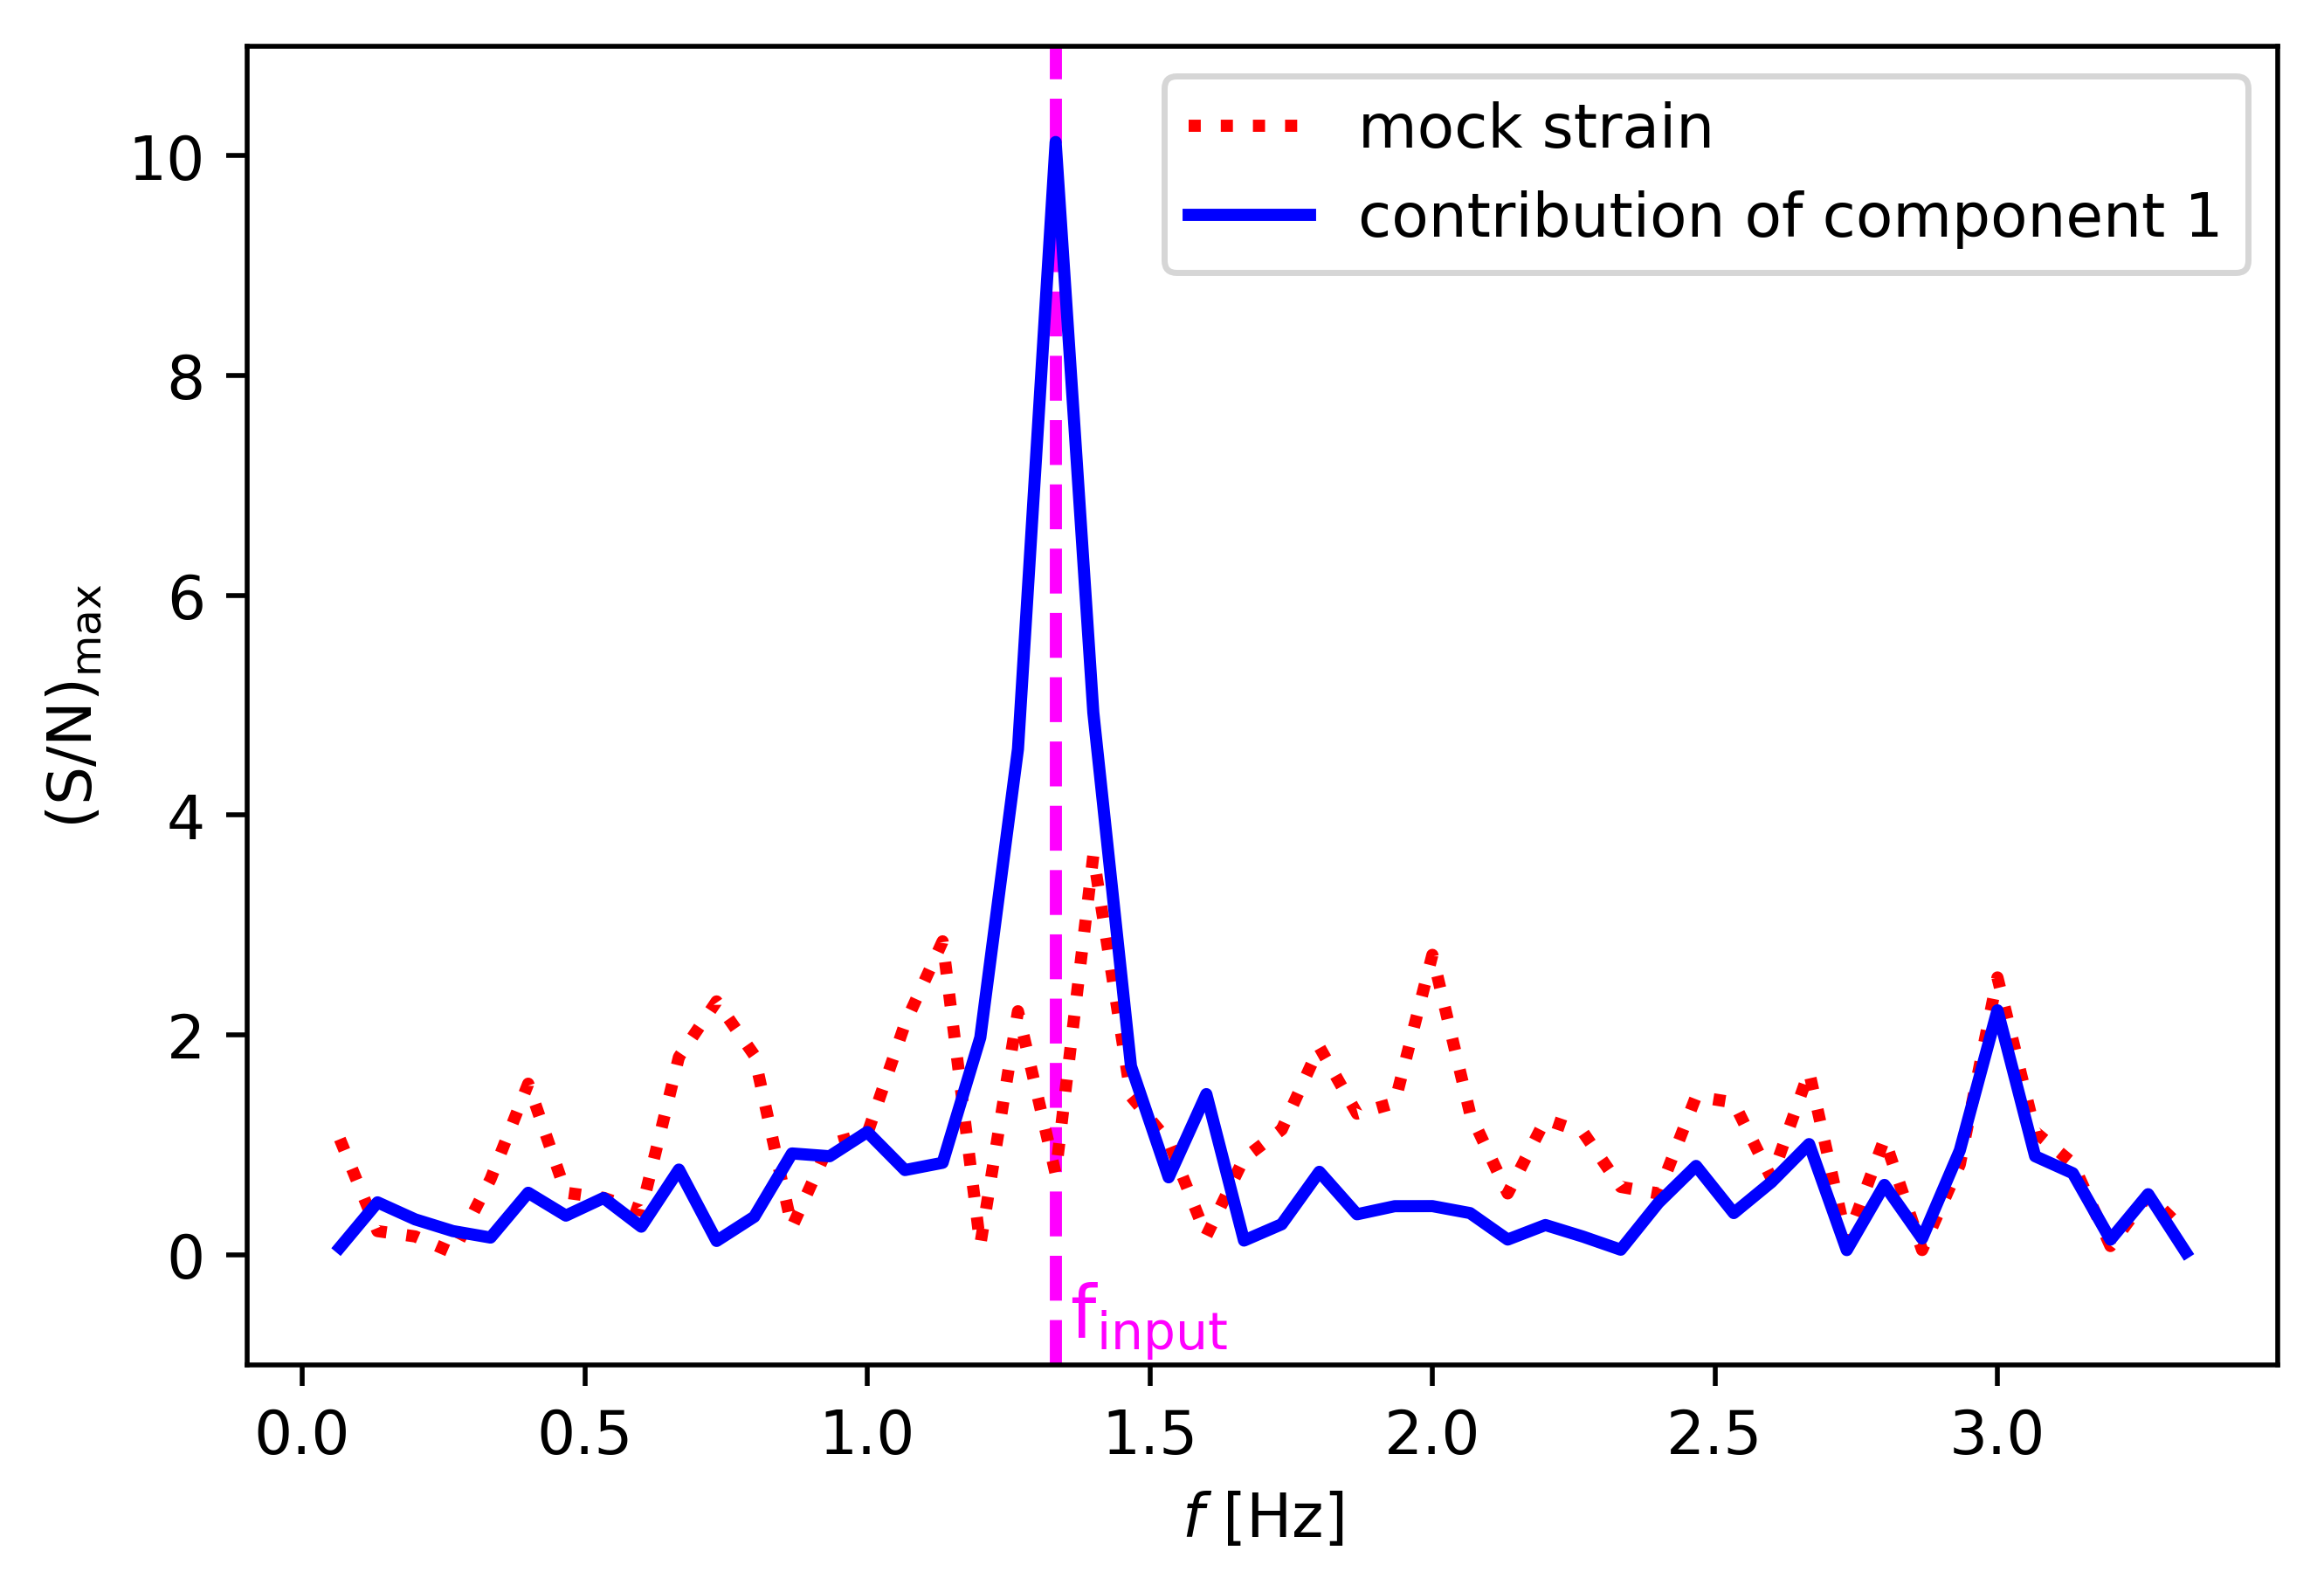

In [63]:
#S/Nのプロット
ymin=-1
ymax=11
plt.figure(dpi=500)
plt.vlines(omega,ymin,ymax,'magenta', linestyles='dashed',linewidth=2.) 
plt.plot(omega_max,Xm_SNR_max,color='red',linestyle='dotted',linewidth=2.,label=r'mock strain')
plt.plot(omega_max,X0m_SNR_max,color='blue',linestyle='solid',linewidth=2.,label=r'contribution of component 1')
#plt.plot(omega_max,X1m_SNR_max,color='black',linestyle='dashed',linewidth=.75,label=r'contribution of component 2')
plt.text(omega+0.025,ymin+0.25,r'f$_{\rm input}$',fontsize='12',color='magenta')
plt.ylim([ymin,ymax])
plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'(S/N)$_{\rm max}$')
plt.legend()
plt.savefig(outdir+outroot+'S2N.png')
plt.show()